In [4]:
import cv2
import glob
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

from random import shuffle

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [7]:
#Load and shuffle data
car_images = glob.glob("data/vehicles/*/*.*")
noncar_images = glob.glob("data/non-vehicles/*/*.*")
shuffle(car_images)
shuffle(noncar_images)

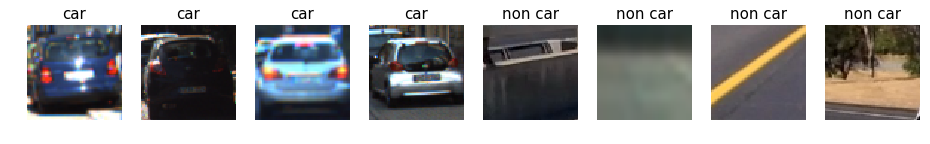

In [8]:
fig, axs = plt.subplots(1,8, figsize=(16, 2))

for i in np.arange(4):
    img = mpimg.imread(car_images[np.random.randint(0,len(car_images))])
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=15)
    axs[i].imshow(img)
for i in np.arange(4,8):
    img = mpimg.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    axs[i].axis('off')
    axs[i].set_title('non car', fontsize=15)
    axs[i].imshow(img)
    plt.savefig('output_images/car_noncar.png', 
            bbox_inches="tight")

In [9]:
#Extract Hog Features Function
#Takes in an image and computes the HOG features in it using hog()
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

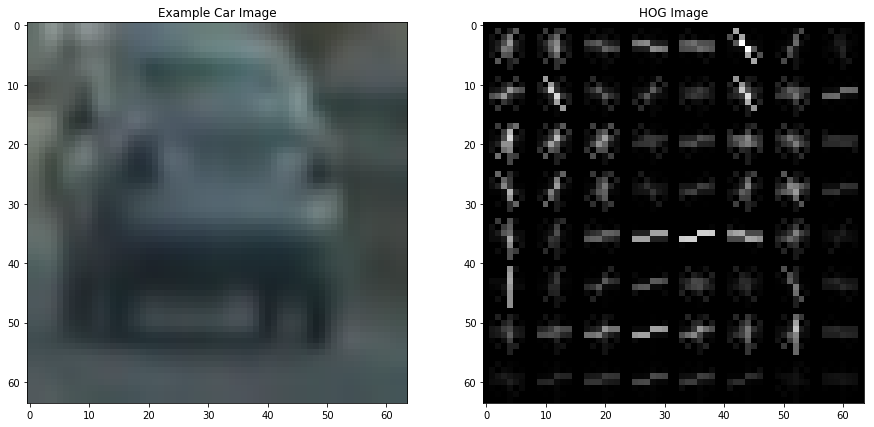

In [10]:
#show example
ind = np.random.randint(0, len(car_images))
image = mpimg.imread(car_images[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
orient = 9
pix_per_cell = 8
cell_per_block = 2
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

fig = plt.figure(figsize = (15,20))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Image')
plt.savefig('output_images/hog.png', 
            bbox_inches="tight")

In [11]:
#Compute Color Histogram Features Function
#Returns concatenated color channels and separate color channels.
def color_hist(img, nbins=32, bins_range=(0, 256), vis=False):
    
    bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Generating bin centers
    bin_edges = channel1_hist[1] #all three bins are the same size
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1])/2
    
    hist_features = np.concatenate((channel1_hist[0],
                                    channel2_hist[0],
                                    channel3_hist[0]))
    if vis == True:
        return channel1_hist, channel2_hist, channel3_hist, bin_centers
    else:
        return hist_features

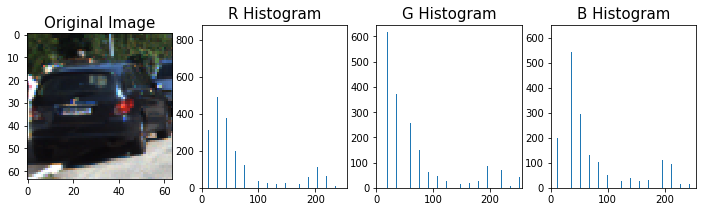

In [12]:
#show histogram
ind = np.random.randint(0, len(car_images))
img = cv2.imread(car_images[ind])
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
channel1_hist, channel2_hist, channel3_hist, bin_centers = color_hist(image, vis=True)
fig = plt.figure(figsize=(12,3));

plt.subplot(141)
plt.imshow(image)
plt.title('Original Image', fontsize=15)
plt.subplot(142)
plt.bar(bin_centers, channel1_hist[0])
plt.xlim(0, 256)
plt.title('R Histogram', fontsize=15);
plt.subplot(143)
plt.bar(bin_centers, channel2_hist[0])
plt.xlim(0, 256)
plt.title('G Histogram', fontsize=15);
plt.subplot(144)
plt.bar(bin_centers, channel3_hist[0])
plt.xlim(0, 256)
plt.title('B Histogram', fontsize=15);

plt.savefig('output_images/hist.png', 
            bbox_inches="tight")

In [13]:
#Spatial Binning of Color features
#Useful for extracting color features from low resolution images.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    #create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    return features

In [14]:
#Extract Features from a list of images Function
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
def extract_features(images, color_space='RGB', spatial_size=(32, 32), 
                     hist_bins=32, orient=9, pix_per_cell=8,
                     cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in tqdm(images):
        file_features = []
        img = mpimg.imread(file) 
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)
            
        if spatial_feat == True:
            # get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False,
                                                feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features

In [15]:
# Similar to extract_features() for a single image
# just for a single image rather than list of images
def single_img_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    img_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True)
        img_features.append(hog_features)
    return np.concatenate(img_features)

In [16]:
#Train HOG Support Vector Classifier
car_features = extract_features(car_images, hog_feat=True)
notcar_features = extract_features(noncar_images, hog_feat=True)
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
# Use a linear SVC
svc = LinearSVC()
svc.fit(X_train, y_train)
print('Test Accuracy of SVC: {0:.2f}%'.format(round(svc.score(X_test, y_test)*100, 4)))

100%|██████████| 8968/8968 [00:19<00:00, 465.45it/s]


Test Accuracy of SVC: 97.30%


In [17]:
#Train Color Histogram Support Vector Classifier
car_features = extract_features(car_images, spatial_feat=True, hist_feat=True)
notcar_features = extract_features(noncar_images, spatial_feat=True, hist_feat=True)
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2,random_state=rand_state)
# Use a linear SVC
svc = LinearSVC()
svc.fit(X_train, y_train)
print('Test Accuracy of SVC: {0:.2f}%'.format(round(svc.score(X_test, y_test)*100, 4)))

100%|██████████| 8968/8968 [00:18<00:00, 478.95it/s]


Test Accuracy of SVC: 97.18%


In [18]:
#Experiments on classifier
color_space = 'YCrCb' # RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 64   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(car_images, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat,
                            hog_feat=hog_feat)
notcar_features = extract_features(noncar_images, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat,
                            hog_feat=hog_feat)

100%|██████████| 8968/8968 [00:40<00:00, 223.82it/s]


In [19]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = {0:.2f}%'.format(round(svc.score(X_test, y_test)*100, 4)))

Test Accuracy of SVC = 98.93%


In [20]:
#Sliding Window Function
#Returns a list of bounding boxes for the search windows
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(128, 128), #(64, 64), (96, 96)
                 xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))

    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 

    window_list = []

    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

In [21]:
#draw bounding boxes
def draw_boxes(img, bboxes, color=(255,0,0), thick=6, random_color=False):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Random color code copied from jeremy-shannon
        if random_color == True:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

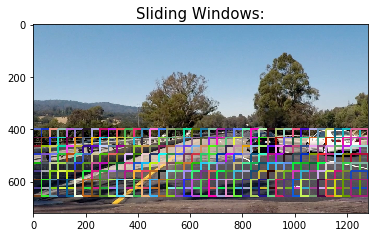

In [22]:
test_img = mpimg.imread('test_images/test4.jpg')

windows =  slide_window(test_img,
                        x_start_stop=[None, None],
                        y_start_stop=[400, 656], #tune the parameters
                        xy_window=(64, 64),
                        xy_overlap=(0.5, 0.5))

window_img = draw_boxes(test_img, windows, random_color=True)
plt.imshow(window_img);
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
plt.title('Sliding Windows:', fontsize=15);
plt.savefig('output_images/sliding-window.png', bbox_inches="tight")

In [23]:
#Pass an image and search for windows
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                   spatial_size=(32, 32), hist_bins=32, orient=9, 
                   pix_per_cell=8, cell_per_block=2, hog_channel=0,
                   spatial_feat=True, hist_feat=True, hog_feat=True):

    #Create an empty list to receive positive detection windows
    on_windows = []
    for window in windows:
        #Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #Extract features for that window
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #Predict
        prediction = clf.predict(test_features)
        #If positive then save the window
        if prediction == 1:
            on_windows.append(window)
    #Return windows for positive detections
    return on_windows

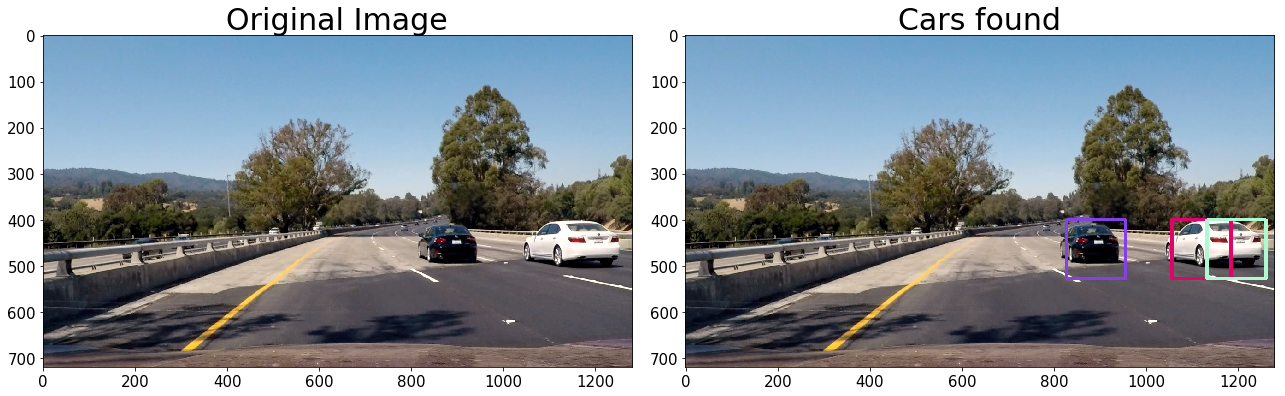

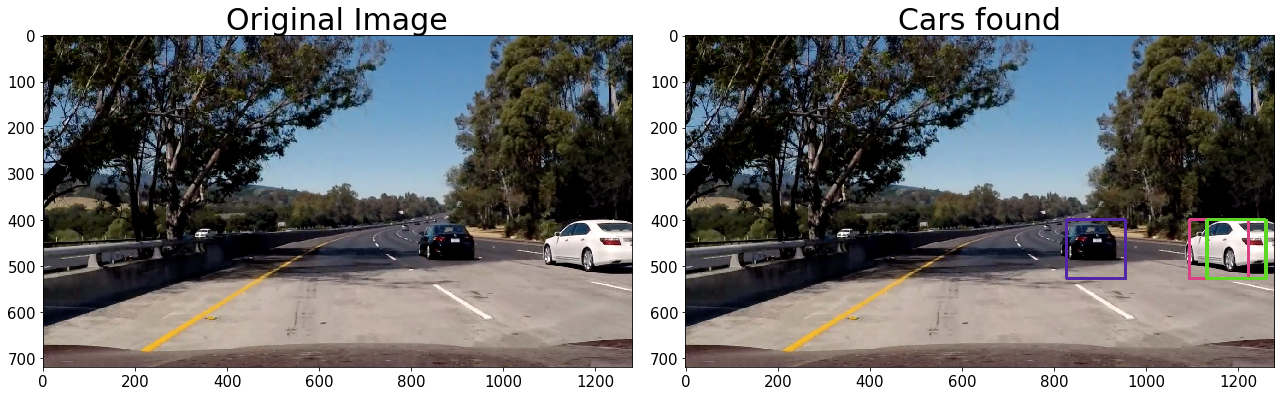

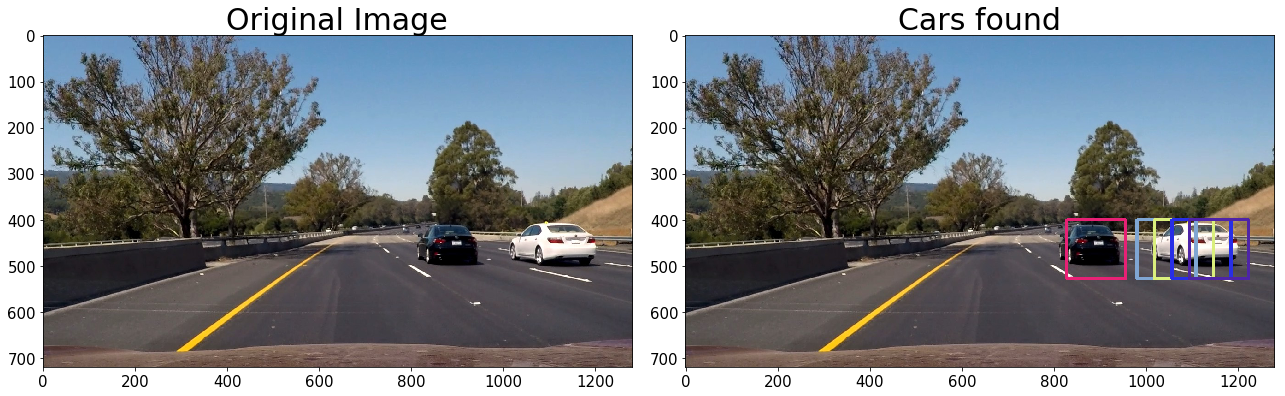

In [24]:
#test an image
test_img = mpimg.imread('test_images/test4.jpg')
for i in range(4,7):
    
    fname = 'test_images/test{}.jpg'.format(i)
    image = mpimg.imread(fname)
    draw_image = np.copy(image)

    image = image.astype(np.float32)/255

    windows =  slide_window(test_img,
                            x_start_stop=[600, None],
                            y_start_stop=[400, 656], #tune the parameters
                            xy_window=(128,128),
                            xy_overlap=(.7,.7))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, random_color=True) 
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,9))
    plt.tight_layout()
    ax1.imshow(draw_image)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(window_img)
    ax2.set_title('Cars found', fontsize=30)
    plt.savefig('output_images/windows.png', bbox_inches="tight")

In [25]:
#Add Heatmaps and Bounding Boxes
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 8)
    return img

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [29]:
#Extracts the HOG and color features, scales them and then makes predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch,
                                     (np.int(imshape[1]/scale),
                                      np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list=[] 
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features,
                                                          hist_features,
                                                          hog_features)).reshape(1, -1))  
            
            # Scale features and make a prediction  
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),
                              (255,0,0),8)
                bbox_list.append(((xbox_left, ytop_draw+ystart), #github.com/preritj
                                  (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    
    return bbox_list

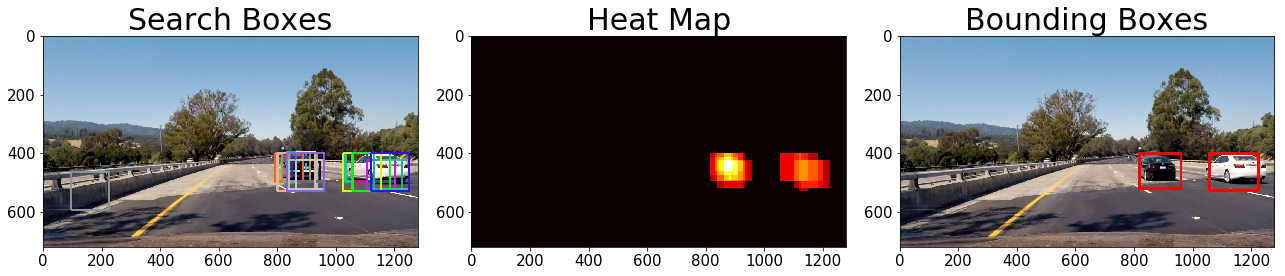

In [30]:
#Testing on heatmmap
for i in range(4,5):
    
    fname = 'test_images/test{}.jpg'.format(i)
    img = mpimg.imread(fname)
    

    orient=10
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    
    bbox_list = []
    
    
    ystart = 380
    ystop = 550
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 600
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 656
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
   
    bbox_list = [item for sublist in bbox_list for item in sublist] 
    
    out_img = draw_boxes(img, bbox_list, random_color=True)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 2)  

    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,9))
    plt.tight_layout()
    ax1.imshow(out_img)
    ax1.set_title('Search Boxes', fontsize=30)
    ax2.imshow(heat, cmap='hot')
    ax2.set_title('Heat Map', fontsize=30)
    ax3.imshow(new_img)
    ax3.set_title('Bounding Boxes', fontsize=30)
    plt.savefig('output_images/heatmap.png', bbox_inches="tight")

In [31]:
def process_image(img):

    orient=10
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    
    bbox_list = []
    
    ystart = 380
    ystop = 550
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 600
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 656
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    bbox_list = [item for sublist in bbox_list for item in sublist] 
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 2)  

    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return new_img

In [27]:
test_output = "test_output.mp4"
clip = VideoFileClip("test_video.mp4")
test_clip = clip.fl_image(process_image)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


 97%|█████████▋| 38/39 [00:31<00:00,  1.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 

CPU times: user 31.3 s, sys: 808 ms, total: 32.1 s
Wall time: 33.3 s


In [28]:
output = "project_output.mp4"
clip = VideoFileClip("project_video.mp4")
clip = clip.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [19:44<00:00,  1.08it/s] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 18min 25s, sys: 35.5 s, total: 19min
Wall time: 19min 45s
